In [1]:
from qutip import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

In [2]:
X = sigmax()
Y = sigmay()
Z = sigmaz()
I = qeye(2)

def Hxxx(N, edges, h=1):
    global X,Y,Z,I
    matrices = [I for i in range(N)]
    sumsigmaz = 0
    sumsigmaxx = 0
    sumsigmayy = 0
    sumsigmazz = 0
    if type(h) is int:
        h *= np.ones(N)
#     if type(J) is int:
#         J *= np.ones(len(edges))        
    for i in range(N):
        matrices[i] = Z
        sumsigmaz += h[i]*tensor(matrices)
        matrices[i] = I    
    for i in range(len(edges)):
        matrices[edges[i][0]] = X
        matrices[edges[i][1]] = X
        sumsigmaxx += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Y
        matrices[edges[i][1]] = Y
        sumsigmayy += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Z
        matrices[edges[i][1]] = Z
        sumsigmazz += edges[i][2]*tensor(matrices)
        matrices[edges[i][0]] = I
        matrices[edges[i][1]] = I  
    H = sumsigmaxx+sumsigmazz+sumsigmayy+ sumsigmaz
    return H

def excstate(N):
    up = tensor([basis(2,0) for n in range(N)])
    state = up*up.dag()
    return state

def most_excited_state(H0):
    excited_state = H0.eigenstates()[1][-1]
    state = excited_state*excited_state.dag()
    return state

def charge(H0, Htot, ancilla, target, tracekeep, times):
    fidel = []
    ergotropy = []
    t = np.linspace(0,1,100)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red0 = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red0*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    for r in range(times):
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        ergotropy.append(W0 - np.sum(RsystEigVal*HsystEigEn)) 
        fidel.append(fidelity(target,Rsyst_red))
        Rin=tensor(ancilla,Rsyst_red)
    return ergotropy, fidel, Rsyst_red 

In [3]:
h = 1 
N0 = 4
times, realizations = 100 , 5
t = np.linspace(0,1,100)

Jall = np.array([[1,1,1,1], [1,1,-1,1], [-1,1,-1,1], [-1,-1,1,-1], [-1,-1,-1,-1]])
J = Jall[-1]
g, p = Jall[0], Jall[0]

charger_names = ['1-0', '2-0', '2-1', '3-0', '3-3', '4-0', '4-4']

edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,1,J[3]]]
edges1 = [[0,1,g[0]],[1,2,J[0]],[2,3,J[1]],[3,4,J[2]],[4,1,J[3]]]
edges20= [[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
edges21= [[0,1,p[0]],[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
edges30= [[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
edges33= [[0,1,p[0]],[1,2,p[1]],[2,0,p[2]],[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
edges40= [[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]
edges44= [[0,1,p[0]],[1,2,p[1]],[2,3,p[2]],[3,1,p[3]],[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]

Fixed Hamiltonian States

In [4]:
import sys
sys.path.append('../')
heisenberg_states = qload('./data/fixedHeisenbergStates')

In [20]:
rho0 = heisenberg_states[1][1]

Define Discharge Hamiltonian

In [21]:
J = Jall[0]
edges = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,1,J[3]]]
H0 = Hxxx(N0, edges, h=np.ones(N0)*2)
#(-1j*H0).expm()*upp*(1j*H0).expm()

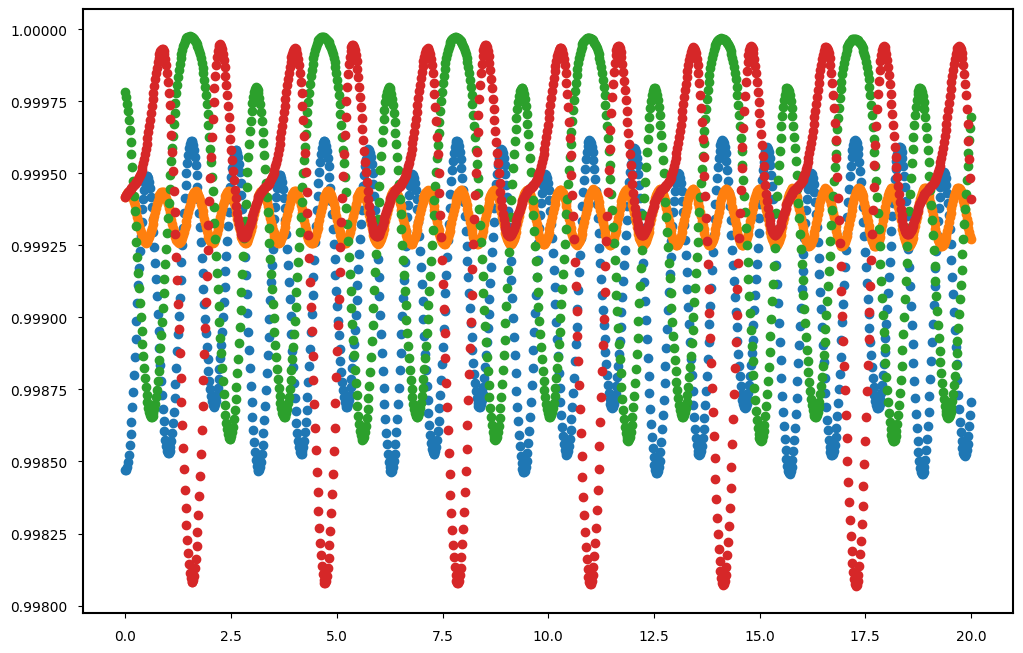

In [27]:
discharge_time = np.linspace(0, 20, 1000)

# Setup operators for individual qubits
sx_list, sy_list, sz_list = [], [], []
for i in range(N0):
    op_list = [qeye(2)] * N0
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

rho0 = heisenberg_states[0][0]
#result = mesolve(H0, rho0, tlist=discharge_time)
result = mesolve(H0, rho0, discharge_time, [], [])
exp_sz = np.array(expect(result.states, sz_list))

yy = []
for i in range(len(discharge_time)):
    yy.append((result.states[i]*H0).tr())

fig, axs = plt.subplots(1,1,figsize=(12,8), dpi=100)
#axs.scatter(discharge_time, yy)
axs.scatter(discharge_time, exp_sz[::,0])
axs.scatter(discharge_time, exp_sz[::,1])
axs.scatter(discharge_time, exp_sz[::,2])
axs.scatter(discharge_time, exp_sz[::,3])
